In [1]:
import numpy as np

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import Aer
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.units import DistanceUnit
from qiskit_nature import settings

from scipy.optimize import minimize

import matplotlib.pyplot as plt

from qiskit_ibm_runtime import Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# Creating a manual VQE for finding the ground state energy of hydrogen

It is not possible to run the code from Qiskit Nature directly on a Quantum Inspire (or IBM) backend, forcing us to create our own VQE. Fortunately we can still make use of many of the Qiskit Nature functions in our code. 

> For detailed documentation on how to run VQE using Qiskit refer to [this](https://learning.quantum.ibm.com/tutorial/variational-quantum-eigensolver#step-1-map-classical-inputs-to-a-quantum-problem) documentation

> For detailed documentation on how to use Qiskit Nature functions in the current version of Qiskit refer to [this](https://qiskit-community.github.io/qiskit-nature/migration/index.html) migration guide.

For this example we will use the IBM qasm_simulator backend. For an example on how to run it on a Quantum Inspire backend, refer to the `qiskit_quantum_inspire.ipynb` example. 

In [2]:
backend = Aer.get_backend("qasm_simulator")

One of the handiest functions in Qiskit Nature is the driver and ansatz functions to create your hamiltonian and from that a quantum circuit. Luckily with minimal modifications we can still make use of these functions. 

 The only modification we have to make is to redefine the hamiltonian created with Qiskit Nature in a `SparsePauliOp` object.
 
To ensure compatibility with future releases of Qiskit, set the value of `use_pauli_sum_op` to False. This will transition from using the deprecated `PauliSumOp` class to the `SparsePauliOp` class in the qiskit.quantum_info module.

After this we create the driver as normal, but will use a loop to set the hamiltonian in the expected format in our `SparsePauliOp` object. 

Here we also define the mapper we use. Experiment with these as they greatly affect performance and might affect accuracy. 

In [3]:
settings.use_pauli_sum_op = False

driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)

electronic_structure = driver.run()

hamiltonian = electronic_structure.hamiltonian.second_q_op()

# mapper = JordanWignerMapper()
mapper = ParityMapper(num_particles=electronic_structure.num_particles)
tapered_mapper = electronic_structure.get_tapered_mapper(mapper)

# qubit_op = mapper.map(hamiltonian)
tapered_op = tapered_mapper.map(hamiltonian)

hamiltonian_list = []

for pauli, coeff in sorted(tapered_op.label_iter()):
    # print(f"{coeff.real:+.8f} * {pauli}")
    hamiltonian_list.append((pauli, coeff.real))
    
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)
print(hamiltonian)

SparsePauliOp(['I', 'X', 'Z'],
              coeffs=[-1.04109314+0.j, -0.1809312 +0.j, -0.79587485+0.j])


Just as in Qiskit Nature, we can use the same objects to create an ansatz, using our mapper. This will greatly simplify creating the quantum circuit of our VQE.

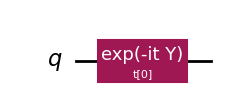

In [4]:
ansatz = UCCSD(
        electronic_structure.num_spatial_orbitals,
        electronic_structure.num_particles,
        tapered_mapper,
        initial_state=HartreeFock(
            electronic_structure.num_spatial_orbitals,
            electronic_structure.num_particles,
            tapered_mapper,
        ),
    )
num_params = ansatz.num_parameters

ansatz.decompose().draw("mpl")

### Transpiling Quantum Circuits for Backend Compatibility
To reduce execution time and ensure compatibility with the backend's instruction set architecture (ISA), we optimize the quantum circuit (ansatz) and Hamiltonian using Qiskit's preset pass manager. Targen is not available on certain backends, therefor we can not use the pass manager. Using `transpile` will offer a similar effect.

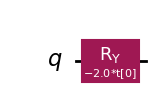

In [5]:
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

# quantum inspire backend does not have a target, so we can't use the pass manager
# ansatz_isa = transpile(ansatz, backend=backend)

ansatz_isa = pm.run(ansatz)

hamiltonian_isa = hamiltonian.apply_layout(layout=ansatz_isa.layout)

ansatz_isa.draw(output="mpl")

### Creating the Cost Function
Like many classical optimization problems, the solution to a VQE problem can be formulated as minimization of a scalar cost function. By definition, VQE looks to find the ground state solution to a Hamiltonian by optimizing the ansatz circuit parameters to minimize the expectation value (energy) of the Hamiltonian. With the Qiskit Runtime Estimator directly taking a Hamiltonian and parameterized ansatz, and returning the necessary energy.

The `run()` method of [Qiskit Runtime](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.EstimatorV2) `EstimatorV2` takes an iterable of `primitive unified blocs` (PUBs). Each PUB is an iterable in the format `(circuit, observables, parameter_values: optional, precision: optional)`

In [6]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0] + nuclear_repulsion_energy

    cost_history["iters"] += 1
    cost_history["prev_vector"] = params
    cost_history["cost_history"].append(energy)
    print(f"Iters. done: {cost_history['iters']} [Current cost: {energy}]")

    return energy

cost_history = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

nuclear_repulsion_energy = electronic_structure.nuclear_repulsion_energy

In [7]:
# set initial point (either random or zero)
# x0 = 2 * np.pi * np.random.random(num_params)
x0 = np.zeros(num_params)
x0

array([0.])

We can now use a classical optimizer of our choice to minimize the cost function. Here, we use the COBYLA routine from [SciPy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) through the `minimize` function. Note that when running on real quantum hardware, the choice of optimizer is important, as not all optimizers handle noisy cost function landscapes equally well.

Because we are sending a large number of jobs that we would like to execute together, we use a `Session` to execute all the generated circuits in one block. Here args is the standard SciPy way to supply the additional parameters needed by the cost function.

In [8]:
with Session(backend=backend) as session:
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 10000

    result = minimize(
        cost_func,
        x0,
        args=(ansatz_isa, hamiltonian_isa, estimator),
        method="cobyla",
    )

/Users/benjamin/Code Projects/HvA/biodac-speeding-up-chemistry-simulations/venv/lib/python3.12/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:247: UserWarning: Options {'default_shots': 10000} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


Iters. done: 1 [Current cost: -1.113995256132585]
Iters. done: 2 [Current cost: 0.18429215533705479]
Iters. done: 3 [Current cost: -0.1596144582535598]
Iters. done: 4 [Current cost: -0.8993483226230364]
Iters. done: 5 [Current cost: -0.9363231262907697]
Iters. done: 6 [Current cost: -1.1364062524492358]
Iters. done: 7 [Current cost: -1.1069200966865882]
Iters. done: 8 [Current cost: -1.1298941881768485]
Iters. done: 9 [Current cost: -1.1372869903709821]
Iters. done: 10 [Current cost: -1.135412766451159]
Iters. done: 11 [Current cost: -1.1293033979407943]
Iters. done: 12 [Current cost: -1.1385942837782466]
Iters. done: 13 [Current cost: -1.1311548482180016]
Iters. done: 14 [Current cost: -1.1399362636619408]
Iters. done: 15 [Current cost: -1.1360837563930066]
Iters. done: 16 [Current cost: -1.1315786885013197]
Iters. done: 17 [Current cost: -1.139688570962972]
Iters. done: 18 [Current cost: -1.1324447983870511]
Iters. done: 19 [Current cost: -1.1341407025607642]
Iters. done: 20 [Current

At the terminus of this routine we have a result in the standard SciPy `OptimizeResult` format. From this we see that it took `nfev` number of cost function evaluations to obtain the solution vector of parameter angles (`x`) that, when plugged into the ansatz circuit, yield the approximate ground state solution we were looking for.

In [9]:
result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -1.1329044112276794
       x: [-8.223e-02]
    nfev: 22
   maxcv: 0.0

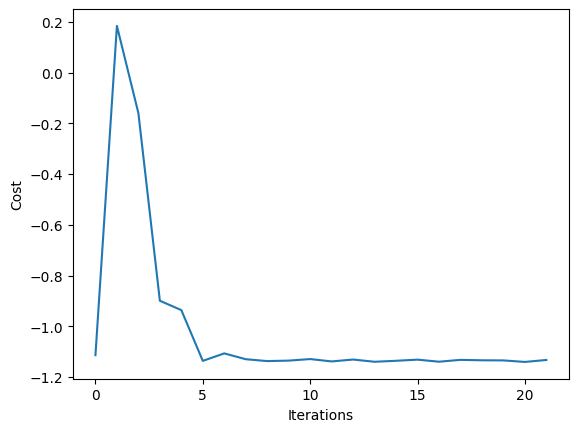

In [10]:
fig, ax = plt.subplots()
ax.plot(range(cost_history["iters"]), cost_history["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()